In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

In [2]:
import sys
sys.path.append('/media/julien/Data1/pro/Dev/HD_Radar/HD_Radar_Processing_Library/rpl_cython')
from RPL_WRAPPER import RPL_wrapper

### initialize library ####
hamming_win = '/media/julien/Data1/pro/Dev/HD_Radar/parameters/WindowStaircaseSilverFeb20.bin'
calib_real = '/media/julien/Data1/pro/Dev/HD_Radar/parameters/Tx_Rx_real_3D.bin'
calib_imag = '/media/julien/Data1/pro/Dev/HD_Radar/parameters/Tx_Rx_imag_3D.bin'

rad = RPL_wrapper(calib_real.encode(),calib_imag.encode(),hamming_win.encode())

numChips            = 4
numRxPerChip        = 4
numRx               = (numChips*numRxPerChip)
numSamplePerChirp   = 512
numChirps           = 256
RawFrameSize        = (numSamplePerChirp*numChirps*numRxPerChip*2)
   
size_max = 10000

azimuth = np.zeros(size_max,dtype = np.float32)
elevation = np.zeros(size_max,dtype = np.float32)
power = np.zeros(size_max,dtype = np.float32)
doppler = np.zeros(size_max,dtype = np.float32)
x = np.zeros(size_max,dtype = np.float32)
y = np.zeros(size_max,dtype = np.float32)
z = np.zeros(size_max,dtype = np.float32)
v = np.zeros(size_max,dtype = np.float32)
r = np.zeros(size_max,dtype = np.float32)

In [3]:
# Import DBReader
sys.path.append('/media/julien/Data1/pro/Dev/HD_Radar/HDRadar_dataset/DBReader')
from DBReader.DBReader import SyncReader,ASyncReader
from DBReader.SensorsReaders import CANDecoder

In [4]:
offset_radar = -180000
offset_scala = -40000

In [367]:
root_dir = '/media/julien/HD_RADAR1/FinalDataset/Pitch0Deg/RECORD@2020-11-22_12.43.28'
root_dir = '/media/julien/HD_RADAR1/FinalDataset/Pitch0Deg/RECORD@2020-11-22_12.54.38'
#root_dir = '/media/julien/HD_RADAR1/FinalDataset/Pitch0Deg/RECORD@2020-11-21_11.54.31'
db = SyncReader(root_dir,tolerance=20000,offset_radar=offset_radar,offset_scala=offset_scala)

-------------------------------------------------------------------------
- Sensors available:
-     radar_ch2
-     camera
-     scala
-     radar_ch1
-     radar_ch3
-     gps
-     radar_ch0
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  0.4329004329004329 %
Total corrupted frames:  2.1645021645021645 %


In [368]:
can_decoder = CANDecoder('buick_enclave_2016.dbc')

In [369]:
from scipy.spatial.transform import Rotation as R

def rotation2d(xy,roll,yaw,pitch):
    
    pitch = np.radians(pitch)
    yaw = np.radians(yaw)
    roll = np.radians(roll)
    
    xyz = np.hstack([xy,np.zeros( (len(xy),1))])
    
    rotation_vector = np.array([roll,pitch,yaw])
    rotation = R.from_rotvec(rotation_vector)
    rotated_vec = rotation.apply(xyz)
    
    return rotated_vec[:,:2]

def rotation3d(x,y,z,roll,yaw,pitch):
    
    pitch = np.radians(pitch)
    yaw = np.radians(yaw)
    roll = np.radians(roll)
    
    xyz = np.stack([x,y,z],axis=1)
    
    rotation_vector = np.array([roll,pitch,yaw])
    rotation = R.from_rotvec(rotation_vector)
    rotated_vec = rotation.apply(xyz)
    
    return rotated_vec[:,0],rotated_vec[:,1],rotated_vec[:,2]


#    float x,y,z;
#    float intensity;
#    float radialDistance;
#    float polAngle,aziAngle;
#    uint8_t layer_index;

def ApplyCalib(pcl,index,yaw):
    
    if(index%2):
        offset = -.50/180*3.14
    else:
        offset = +.10/180*3.14
    
    offset+=0.5/180*3.14
    
    x = pcl[:,4] * np.cos(pcl[:,5]+offset) * np.cos(pcl[:,6]+yaw)
    y = pcl[:,4] * np.cos(pcl[:,5]+offset) * np.sin(pcl[:,6]+yaw)
    z = pcl[:,4] * np.sin(pcl[:,5]+offset) + 0.37#0.42
    
    pcl[:,0] = x
    pcl[:,1] = y
    pcl[:,2] = z
    
    return pcl

In [370]:
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
from sklearn import linear_model

def remove_ground(xyz):
    
    id = np.where( (xyz[:,1]>-5) &  (xyz[:,1]<5) & (xyz[:,0]<15)& (xyz[:,0]>2))[0]
    X = xyz[id,0].reshape((-1, 1))
    y = xyz[id,2]
    lr = linear_model.RANSACRegressor()
    lr.fit(X,y)
    id = np.where( (xyz[:,2] > 0.1+(xyz[:,0] * lr.estimator_.coef_[0])))[0]
    
    return xyz[id,:]

In [371]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

sys.path.insert(0,'/media/julien/Data1/pro/Dev/HD_Radar/2D_detection/pytorch-retinanet')

from retinanet.dataloader import CocoDataset, CSVDataset, CityscapesDataset,collater
from retinanet.dataloader import Resizer, AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer

retinanet = torch.load('/media/julien/Data1/pro/Dev/HD_Radar/2D_detection/pytorch-retinanet/SecondRun/retinanet_45.pt')
retinanet = retinanet.cuda()
retinanet.eval()
transform=transforms.ToTensor()

In [372]:
camera_matrix = np.array([[1.84541929e+03, 0.00000000e+00, 8.55802458e+02],
                 [0.00000000e+00 , 1.78869210e+03 , 6.07342667e+02],[0.,0.,1]])
dist_coeffs = np.array([2.51771602e-01,-1.32561698e+01,4.33607564e-03,-6.94637533e-03,5.95513933e+01])
rvecs = np.array([1.61803058, 0.03365624,-0.04003127])
tvecs = np.array([0.09138029,1.38369885,1.43674736])

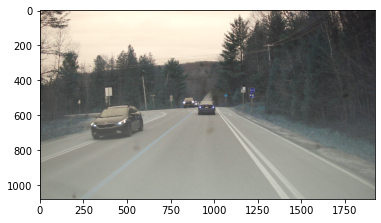

In [417]:
start = 450


datas=db.GetSensorData(start)
img = datas['camera']['data']
plt.imshow(img)

In [418]:
cv2.imwrite('image{:05d}.png'.format(start),img)

True

In [358]:
def remove_obstacles_points(image,x,y):
    
    img = image.copy().astype(np.float32)/255.0
    img2 = cv2.resize(img,dsize=(960,544))
    ratioX = img.shape[1]/960
    ratioY = img.shape[0]/544
    img3 = (img2-np.array([[[0.485, 0.456, 0.406]]]))/np.array([[[0.229, 0.224, 0.225]]])
    img3 = transform(img3).unsqueeze(0)
    nms_scores, nms_class, boxes = retinanet(img3.cuda().float())
    boxes = boxes.detach().cpu().numpy()
    boxes[:,0]*=ratioX
    boxes[:,2]*=ratioX
    boxes[:,1]*=ratioY
    boxes[:,3]*=ratioY

    nms_scores = nms_scores.detach().cpu().numpy()
    nms_class = nms_class.detach().cpu().numpy()

    det=[]
    for s,c,b in zip(nms_scores, nms_class, boxes):
        if(s>0.5 and c==0):
            det.append(b)
            
    ############# Remove points in objects boxes
    # Project Radar points in image
    NBPts=len(x)
    objectPoints = np.zeros((NBPts,3))
    objectPoints[:,0]=y
    objectPoints[:,1]=x
    objectPoints[:,2]=0.6
    imgpts, _ = cv2.projectPoints(objectPoints, rvecs, tvecs, camera_matrix, dist_coeffs)
    imgpts=imgpts.squeeze(1)
    imgpts=imgpts.astype('int')
    
    id_used = []
    for i,bb in enumerate(boxes):
        x1 = bb[0]
        y1 = bb[1]
        x2 = bb[2]
        y2 = bb[3]
       
        # does it contains radar poinst?
        id_rad = np.where( (imgpts[:,0]>=x1) & (imgpts[:,0]<=x2) & (imgpts[:,1]>=y1) & (imgpts[:,1]<=y2))[0]
        id_used.append(id_rad)
        
    if(len(id_used)==0):
        return x,y
        
    remainPoints = np.setdiff1d(np.arange(len(imgpts)),np.unique(np.concatenate(id_used)))
    print(len(remainPoints)/len(imgpts)*100,'%')
    x = x[remainPoints]
    y = y[remainPoints] 
    
    return x,y

100.0 %
0 2.5011708320652306 -0.01743727665863478 -0.399642 -2.0
100.0 %
2.5012316145833333 2.5101381887362395 -0.036652645169772125 -0.43734687499999997 -2.1875
100.0 %
5.011637387152778 2.5201455414341623 -0.056031880350758234 -0.43733812499999997 -2.1875
100.0 %
7.532405746527777 2.5390968310856574 -0.07588022158675521 -0.438300625 -2.1875
96.40718562874252 %
10.072636154513887 2.541408749619873 -0.09699510157075615 -0.474164 -2.375
96.6355140186916 %
12.615895182291665 2.546154237415499 -0.12164640968683677 -0.54990925 -2.75
97.67857142857143 %
15.164953684895831 2.5504459848189716 -0.1446677634329093 -0.511428875 -2.5625
98.53211009174312 %
17.7194993359375 2.5529665739964926 -0.1676690559489812 -0.511346875 -2.5625
95.75551782682513 %
20.27796591579861 2.5632822622024234 -0.19136135569090876 -0.5121745625 -2.5625
95.43147208121827 %
22.848381276041664 2.57138118348064 -0.2150801550714699 -0.5120823124999999 -2.5625
95.79967689822294 %
25.428741844618052 2.5772598879508535 -0.2370

(0.0, 100.0)

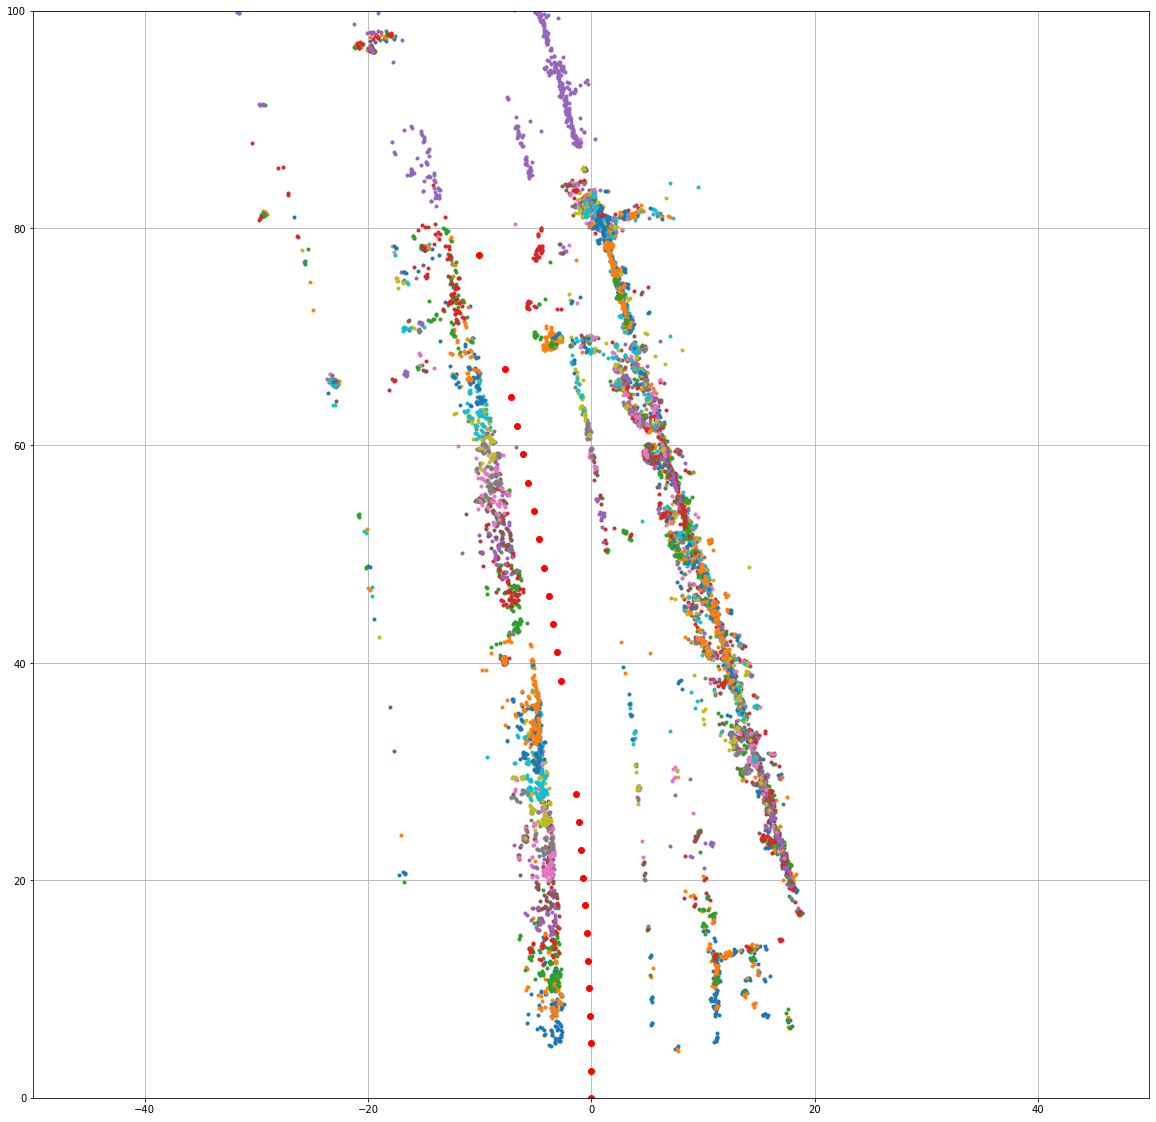

In [359]:
# Build free space on next 100m
pos = [0,0]
absolute_angle = 0

data = db.df_filtered.to_numpy()

position=[]
position.append(pos.copy())
init= True

pts = []

plt.figure(figsize=(20,20))

TotDist = 0
max_dist = 40
max_range = 80

for i in np.arange(start,len(db)):
    
    datas=db.GetSensorData(i)
    timestamp = datas['scala']['timestamp']
    SteeringWheel,YawRate,VehSpdAvgDrvn = db.GetMostRecentOdometry(can_decoder,timestamp)
    #print('timestamp: ',timestamp,'timeofissue: ',timeofissue,'Sensor: ',sensor,'sample: ',sample)



    #################### RADAR
    rad.process(datas['radar_ch3']['data'],datas['radar_ch0']['data'],datas['radar_ch1']['data'],datas['radar_ch2']['data'])

    size_max = 10000

    azimuth = np.zeros(size_max,dtype = np.float32)
    elevation = np.zeros(size_max,dtype = np.float32)
    power = np.zeros(size_max,dtype = np.float32)
    doppler = np.zeros(size_max,dtype = np.float32)
    x = np.zeros(size_max,dtype = np.float32)
    y = np.zeros(size_max,dtype = np.float32)
    z = np.zeros(size_max,dtype = np.float32)
    v = np.zeros(size_max,dtype = np.float32)
    r = np.zeros(size_max,dtype = np.float32)
    
    NBPts = rad.get_pcl(r,azimuth,elevation,power,doppler, x,y,z,v,size_max)

    x = x[:NBPts] # Longi
    y = y[:NBPts] # Lateral


    if(init):
        init=False
        previousTime = timestamp

        # Do not remove obstacle on first frame, obstacles have to appear here
        data = np.vstack([x,y]).transpose()
        id = np.where((data[:,0]<max_dist) & (data[:,1]<20) & (data[:,1]>-20))[0]
        data=data[id,:]
    
    
        data2 = data.copy()
        
        plt.plot(data2[:,1],data2[:,0],'.')
        plt.plot(pos[1],pos[0],'ro')
    
        pts.append(data2)
        continue
    
    x,y = remove_obstacles_points(datas['camera']['data'],x,y)
    data = np.vstack([x,y]).transpose()
    id = np.where((data[:,0]<max_dist) & (data[:,1]<20) & (data[:,1]>-20))[0]
    data=data[id,:]
    
    # Estimate motiom
    dT_sec = (timestamp-previousTime)/1e6
    relative_angle = YawRate*dT_sec
    absolute_angle +=relative_angle
    dist = VehSpdAvgDrvn*1000/3600 *dT_sec
    Dx = np.cos(absolute_angle/180*3.14)*dist # Longi
    Dy = np.sin(absolute_angle/180*3.14)*dist # Lat

    print(TotDist,Dx,Dy,relative_angle,YawRate)
    TotDist+=dist
    if(TotDist>max_range):
        break
    pos[0]+=Dx
    pos[1]+=Dy
    
    previousTime = timestamp
    data2 = data.copy()
    data3 = rotation2d(data2,0,absolute_angle,0)
    
    data3[:,0]+=pos[0]
    data3[:,1]+=pos[1]
    
    
    plt.plot(data3[:,1],data3[:,0],'.')
    plt.plot(pos[1],pos[0],'ro')
    
    pts.append(data3)
    
    #print(pos[0],pos[1])
    position.append(pos.copy())
    
position=np.vstack(position)
plt.grid()
plt.xlim(-50,50)
plt.ylim(0.,100)

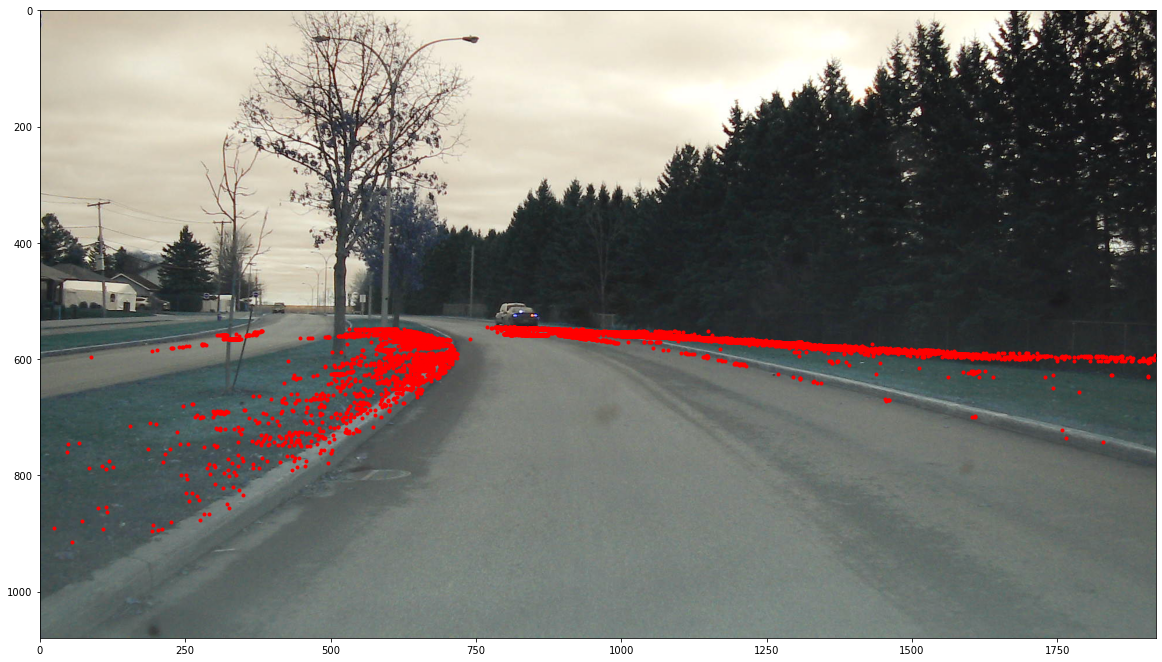

In [360]:
datas=db.GetSensorData(start)
pts=np.vstack(pts)

fig, ax = plt.subplots(figsize=(20,20))

# Display the image
ax.imshow(datas['camera']['data'])

# Project Radar points in image
NBPts=len(pts)
objectPoints = np.zeros((NBPts,3))
objectPoints[:,0]=pts[:,1]
objectPoints[:,1]=pts[:,0]
objectPoints[:,2]=0
imgpts, _ = cv2.projectPoints(objectPoints, rvecs, tvecs, camera_matrix, dist_coeffs)
imgpts=imgpts.squeeze(1)
imgpts=imgpts.astype('int')

    
for pt in imgpts:
    if(pt[0]>=0 and pt[1]>=0 and pt[1]<img.shape[0] and pt[0]<img.shape[1]):
        ax.plot(pt[0],pt[1],'r.')

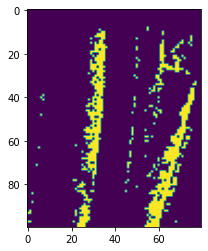

In [361]:
# build an occupancy grid map
# map: [50m*40m]
# in Cartesian:
map = np.zeros((50*2,40*2))
for pt in pts:
    x = int(pt[0]*2)
    y = int(pt[1]*2)+40
    
    if(x>=0 and y>=0 and x<100 and y<80):
        map[x,y]+=1
        
plt.imshow(map>0)

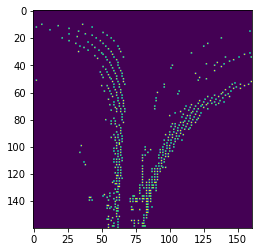

In [362]:
# build an occupancy grid map
# map: [50m*180deg]
# in Polar:
range_max = 80
angle_max = 40
resolution_m = 0.5
resolution_deg = 0.5

bin_range = int(range_max/resolution_m)
bin_angle = int(angle_max*2 / resolution_deg + 1)
map = np.zeros((bin_range,bin_angle))
for pt in pts:
    x = int(pt[0])
    y = int(pt[1])
    
    range = int(np.sqrt(x*x+y*y) /resolution_m)
    azimuth = int( (np.arctan(y/(x+0.001))*180/3.14 + angle_max)/resolution_deg)
    
    
    if(range>=0 and azimuth>=0 and range<bin_range and azimuth<bin_angle):
        map[range,azimuth]+=1
        
plt.imshow(map>1)

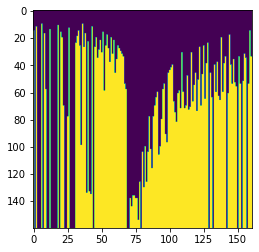

In [363]:
y,x = map.nonzero()
for yy,xx in zip(y,x):
    map[yy:,xx] = 1
plt.imshow(map)

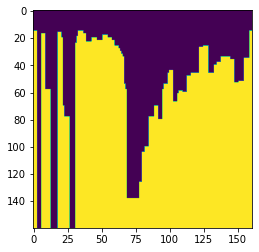

In [364]:
import skimage.morphology as morph

close = morph.binary_closing(map,selem=np.ones((1,3)))
open = morph.binary_opening(close,selem=np.ones((1,3)))
plt.imshow(open)

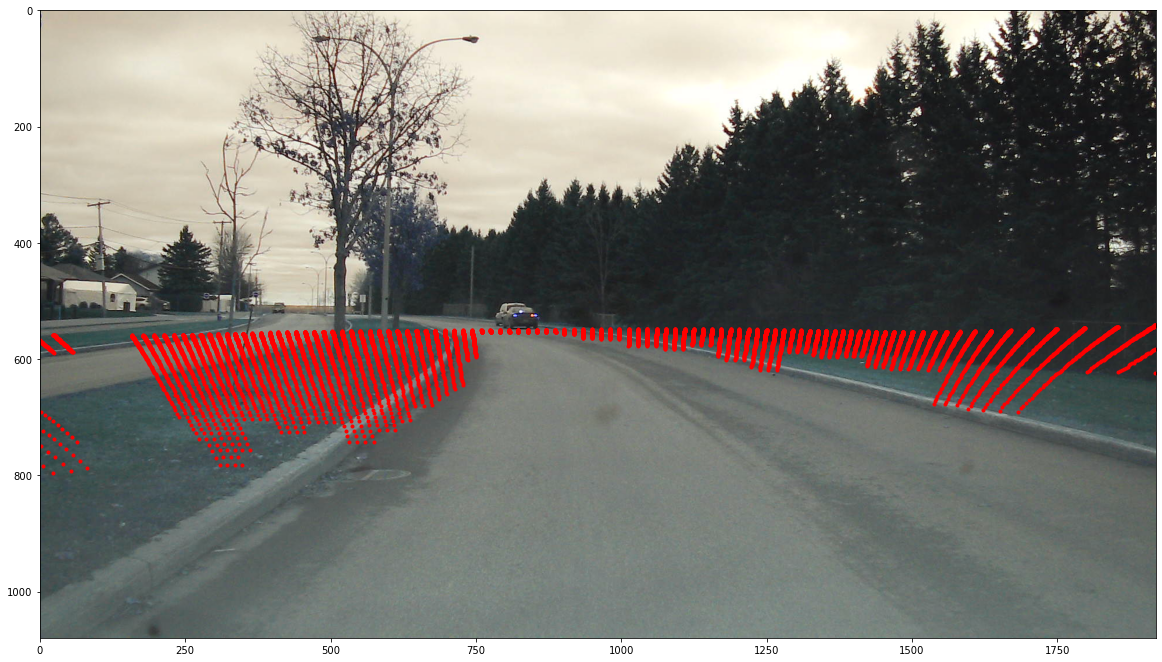

In [365]:
r,a = open.nonzero()

fig, ax = plt.subplots(figsize=(20,20))

# Display the image
ax.imshow(datas['camera']['data'])

NBPts=len(r)
objectPoints2 = np.zeros((NBPts,3))
for i in np.arange(NBPts):
    rr = r[i]*resolution_m
    angle = (a[i]-open.shape[1]/2)*resolution_deg * 3.14/180
    objectPoints2[i,0]=  np.sin(angle)*rr
    objectPoints2[i,1]= np.cos(angle)*rr
    objectPoints2[i,2] = 0.2
    
imgpts, _ = cv2.projectPoints(objectPoints2, rvecs, tvecs, camera_matrix, dist_coeffs)
imgpts=imgpts.squeeze(1)
imgpts=imgpts.astype('int')

    
for pt in imgpts:
    if(pt[0]>=0 and pt[1]>=0 and pt[1]<img.shape[0] and pt[0]<img.shape[1]):
        ax.plot(pt[0],pt[1],'r.')

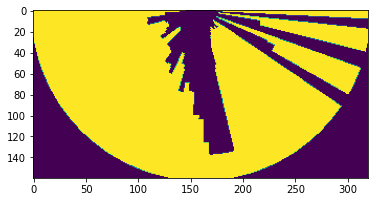

In [366]:
import polarTransform

RA_cartesian,_=polarTransform.convertToCartesianImage(open.transpose(),useMultiThreading=True,
        initialAngle=0, finalAngle=np.pi,order=0)

plt.imshow(RA_cartesian)

In [165]:
y,x = np.where(RA_cartesian>0)
print(len(x))

13708


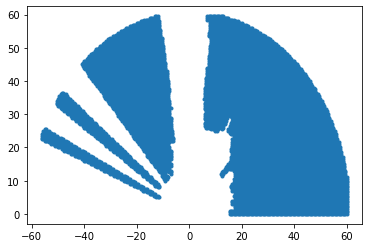

In [166]:
# Project Radar points in image
NBPts=len(y)
objectPoints2 = np.zeros((NBPts,3))
for i in np.arange(NBPts):
    objectPoints2[i,0]= -(x[i] - (RA_cartesian.shape[1]/2)) * resolution_m
    objectPoints2[i,1]= y[i] * resolution_m
    objectPoints2[i,2] = 0.2
    
plt.plot(objectPoints2[:,0],objectPoints2[:,1],'.')

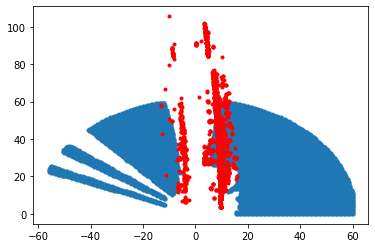

In [167]:
plt.plot(objectPoints2[:,0],objectPoints2[:,1],'.')
plt.plot(pts[:,1],pts[:,0],'r.')

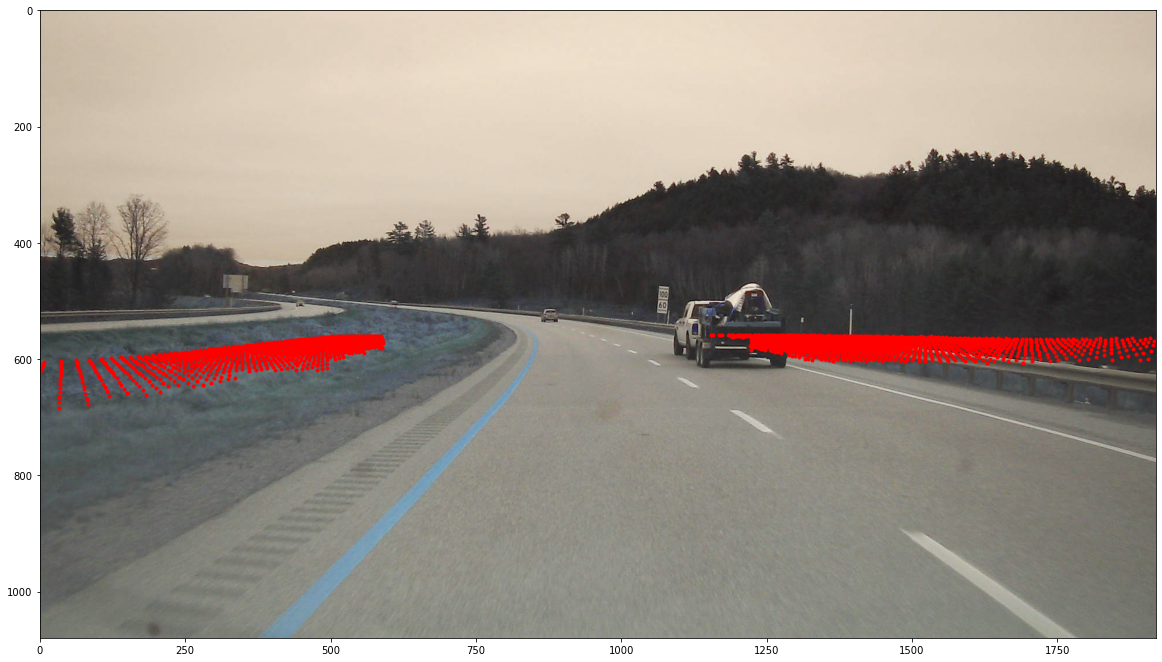

In [156]:
fig, ax = plt.subplots(figsize=(20,20))

# Display the image
ax.imshow(datas['camera']['data'])

imgpts, _ = cv2.projectPoints(objectPoints2, rvecs, tvecs, camera_matrix, dist_coeffs)
imgpts=imgpts.squeeze(1)
imgpts=imgpts.astype('int')

    
for pt in imgpts:
    if(pt[0]>=0 and pt[1]>=0 and pt[1]<img.shape[0] and pt[0]<img.shape[1]):
        ax.plot(pt[0],pt[1],'r.')

In [93]:
objectPoints2

array([[-60. ,   0. ,   0.2],
       [-59.5,   0. ,   0.2],
       [-59. ,   0. ,   0.2],
       ...,
       [ 12. ,  59.5,   0.2],
       [ 12.5,  59.5,   0.2],
       [ 13. ,  59.5,   0.2]])

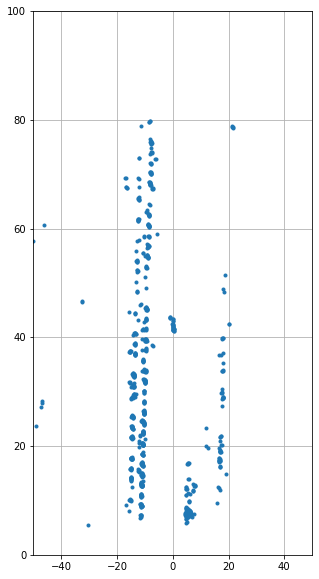

In [323]:
datas=db.GetSensorData(start)
rad.process(datas['radar_ch3']['data'],datas['radar_ch0']['data'],datas['radar_ch1']['data'],datas['radar_ch2']['data'])
NBPts = rad.get_pcl(r,azimuth,elevation,power,doppler, x,y,z,v,size_max)
x = x[:NBPts]
y = y[:NBPts]
doppler = doppler[:NBPts]

plt.figure(figsize=(5,10))
plt.plot(y,x,'.')
plt.xlim(-50,50)
plt.ylim(0.,100)
plt.grid()

In [229]:
plt.figure(figsize=(20,20))

plt.plot(pts[:,0],pts[:,1],'g.')
plt.plot(position[:,0],position[:,1],'r.')

TypeError: list indices must be integers or slices, not tuple

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# Create an iterator on the dataset
ite = iter(db)

# iterate through the entire dataset
# it replays the data with the same order it has been recorded
# it s sequential, that is to say each data will be from one of the sensor, but
# not all at the same time
# Please, take into account that the timeofissue are ordered but the timestamp are from the sensor, so 
# an offset has to be applied

pos = [0,0]
absolute_angle = 0

data = db.df_filtered.to_numpy()

position=[]
position.append(pos.copy())
init= True

pts = []

plt.figure(figsize=(20,20))

for i in range(0,150,1):#len(db)):
    
    datas=db.GetSensorData(i)
    

    timestamp = datas['scala']['timestamp']

    #print('timestamp: ',timestamp,'timeofissue: ',timeofissue,'Sensor: ',sensor,'sample: ',sample)
    
    SteeringWheel,YawRate,VehSpdAvgDrvn = db.GetMostRecentOdometry(can_decoder,timestamp)
    
    
    rad.process(datas['radar_ch3']['data'],datas['radar_ch0']['data'],datas['radar_ch1']['data'],datas['radar_ch2']['data'])

    size_max = 10000

    azimuth = np.zeros(size_max,dtype = np.float32)
    elevation = np.zeros(size_max,dtype = np.float32)
    power = np.zeros(size_max,dtype = np.float32)
    doppler = np.zeros(size_max,dtype = np.float32)
    x = np.zeros(size_max,dtype = np.float32)
    y = np.zeros(size_max,dtype = np.float32)
    z = np.zeros(size_max,dtype = np.float32)
    v = np.zeros(size_max,dtype = np.float32)
    r = np.zeros(size_max,dtype = np.float32)
    
    NBPts = rad.get_pcl(r,azimuth,elevation,power,doppler, x,y,z,v,size_max)


    x = x[:NBPts] # Longi
    y = y[:NBPts] # Lateral


    data = np.vstack([x,y]).transpose()
    
    id = np.where((data[:,0]<30) & (data[:,1]<15) & (data[:,1]>-15))[0]
    data=data[id,:]
    if(init):
        init=False
        previousTime = timestamp
        
        data2 = data.copy()
        
        plt.plot(data2[:,1],data2[:,0],'.')
        plt.plot(pos[1],pos[0],'ro')
    
        pts.append(data2)
        continue
    
    # Estimate motiom
    dT_sec = (timestamp-previousTime)/1e6
    relative_angle = -YawRate*dT_sec
    absolute_angle +=relative_angle
    dist = VehSpdAvgDrvn*1000/3600 *dT_sec
    Dx = np.cos(absolute_angle/180*3.14)*dist # Longi
    Dy = np.sin(absolute_angle/180*3.14)*dist # Lat

    print(dT_sec,VehSpdAvgDrvn,Dx,Dy,absolute_angle)
    pos[0]+=Dx
    pos[1]+=Dy
    
    previousTime = timestamp
    data2 = data.copy()
    data3 = rotation2d(data2,0,absolute_angle,0)
    
    data3[:,0]+=pos[0]
    data3[:,1]+=pos[1]
    
 
    
    
    plt.plot(data3[:,1],data3[:,0],'.')
    plt.plot(pos[1],pos[0],'ro')
    
    pts.append(data3)
    
    #print(pos[0],pos[1])
    position.append(pos.copy())
    
position=np.vstack(position)
#pts=np.vstack(pts)

In [31]:
# Create an iterator on the dataset
ite = iter(db)

# iterate through the entire dataset
# it replays the data with the same order it has been recorded
# it s sequential, that is to say each data will be from one of the sensor, but
# not all at the same time
# Please, take into account that the timeofissue are ordered but the timestamp are from the sensor, so 
# an offset has to be applied

pos = [0,0]
absolute_angle = 0

data = db.df_filtered.to_numpy()

position=[]
position.append(pos)
init= True

pts = []

for i in range(len(db)):
    print(i,len(db))
    
    datas=db.GetSensorData(i)
    

    timestamp = datas['scala']['timestamp']

    #print('timestamp: ',timestamp,'timeofissue: ',timeofissue,'Sensor: ',sensor,'sample: ',sample)
    
    SteeringWheel,YawRate,VehSpdAvgDrvn = db.GetMostRecentOdometry(can_decoder,timestamp)
    
    
    '''rad.process(datas['radar_ch3']['data'],datas['radar_ch0']['data'],datas['radar_ch1']['data'],datas['radar_ch2']['data'])

    size_max = 10000

    azimuth = np.zeros(size_max,dtype = np.float32)
    elevation = np.zeros(size_max,dtype = np.float32)
    power = np.zeros(size_max,dtype = np.float32)
    doppler = np.zeros(size_max,dtype = np.float32)
    x = np.zeros(size_max,dtype = np.float32)
    y = np.zeros(size_max,dtype = np.float32)
    z = np.zeros(size_max,dtype = np.float32)
    v = np.zeros(size_max,dtype = np.float32)
    r = np.zeros(size_max,dtype = np.float32)
    
    NBPts = rad.get_pcl(r,azimuth,elevation,power,doppler, x,y,z,v,size_max)


    x = x[:NBPts]
    y = y[:NBPts]
    doppler = doppler[:NBPts]'''


    data = datas['scala']['data']
    sample_number = datas['scala']['sample_number']
    
    id = np.where((data[:,0]>25) & (data[:,0]<40) & (data[:,1]<20) & (data[:,1]>-20))[0]
    data=data[id,:]
    if(init):
        init=False
        previousTime = timestamp
        
        data = ApplyCalib(data,sample_number,absolute_angle)
        
        data2 = data.copy()#remove_ground(data.copy())
        
        id=np.where( (data2[:,0]<5) & (data2[:,1]<10) & (data2[:,1]>-10))[0]
        
        pts.append(data2[id,:3])
        continue
        
    # Estimate motiom
    dT_sec = (timestamp-previousTime)/1e6
    relative_angle = -YawRate*dT_sec
    absolute_angle +=relative_angle
    dist = VehSpdAvgDrvn*1000/3600 *dT_sec
    Dx = np.cos(absolute_angle/180*3.14)*dist
    Dy = np.sin(absolute_angle/180*3.14)*dist
    
    pos[0]+=Dx
    pos[1]+=Dy
    
    
    data2 = data.copy()#remove_ground(data.copy())
    data3 = ApplyCalib(data2.copy(),sample_number,absolute_angle/180*3.14)
    
    id=np.where((data3[:,0]<5) & (data3[:,1]<10) & (data3[:,1]>-10))[0]
    
    data3 = data3[id]
    
    data3[:,0]+=pos[0]
    data3[:,1]+=pos[1]
    
 
    previousTime = timestamp
    
    pts.append(data3[:,:3])
    
    #print(pos[0],pos[1])
    position.append(pos.copy())
    
position=np.vstack(position)
pts=np.vstack(pts)

0 372
1 372
2 372
3 372
4 372
5 372
6 372
7 372
8 372
9 372
10 372
11 372
12 372
13 372
14 372
15 372
16 372
17 372
18 372
19 372
20 372
21 372
22 372
23 372
24 372
25 372
26 372
27 372
28 372
29 372
30 372
31 372
32 372
33 372
34 372
35 372
36 372
37 372
38 372
39 372
40 372
41 372
42 372
43 372
44 372
45 372
46 372
47 372
48 372
49 372
50 372
51 372
52 372
53 372
54 372
55 372
56 372
57 372
58 372
59 372
60 372
61 372
62 372
63 372
64 372
65 372
66 372
67 372
68 372
69 372
70 372
71 372
72 372
73 372
74 372
75 372
76 372
77 372
78 372
79 372
80 372
81 372
82 372
83 372
84 372
85 372
86 372
87 372
88 372
89 372
90 372
91 372
92 372
93 372
94 372
95 372
96 372
97 372
98 372
99 372
100 372
101 372
102 372
103 372
104 372
105 372
106 372
107 372
108 372
109 372
110 372
111 372
112 372
113 372
114 372
115 372
116 372
117 372
118 372
119 372
120 372
121 372
122 372
123 372
124 372
125 372
126 372
127 372
128 372
129 372
130 372
131 372
132 372
133 372
134 372
135 372
136 372
137 372
138 37

In [32]:
position=np.vstack(position)
pts=np.vstack(pts)

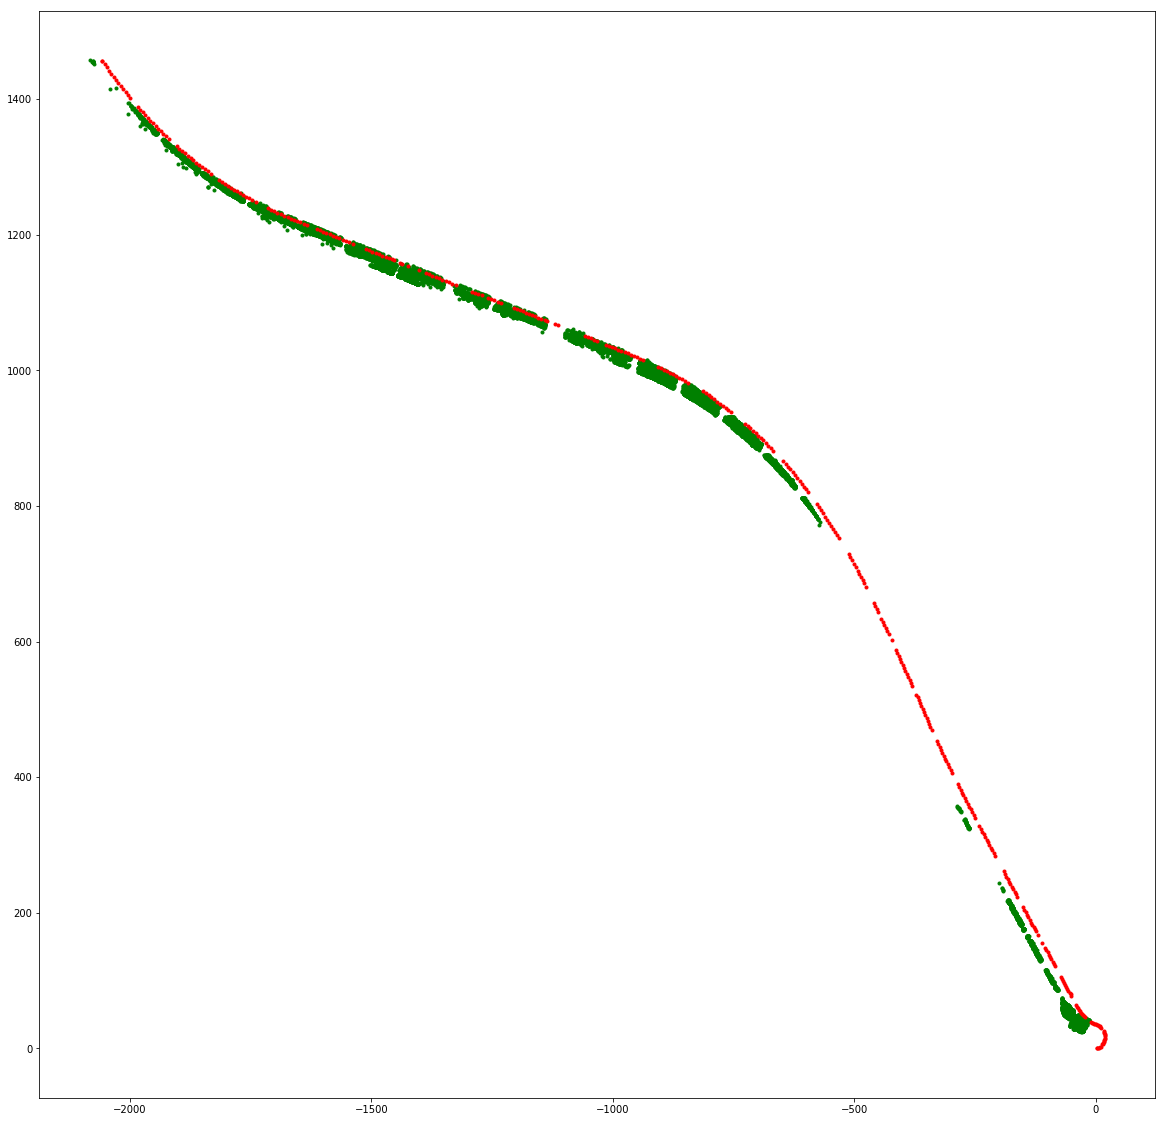

In [33]:
plt.figure(figsize=(20,20))

plt.plot(pts[:,0],pts[:,1],'g.')
plt.plot(position[:,0],position[:,1],'r.')
#plt.plot(pts[1][:,0],pts[1][:,1],'b.')

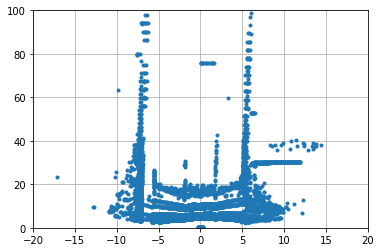

In [106]:
# Create an iterator on the dataset
ite = iter(db)

# iterate through the entire dataset
# it replays the data with the same order it has been recorded
# it s sequential, that is to say each data will be from one of the sensor, but
# not all at the same time
# Please, take into account that the timeofissue are ordered but the timestamp are from the sensor, so 
# an offset has to be applied

pos = [0,0]
absolute_angle = 0

data = db.df_filtered.to_numpy()

position=[]
position.append(pos)
init= True

pts = []

for i in range(len(db)):
    
    ite = len(db) - 1 - i
    
    print(ite)
    
    datas=db.GetSensorData(ite)
    timestamp = datas['scala']['timestamp']
    SteeringWheel,YawRate,VehSpdAvgDrvn = db.GetMostRecentOdometry(can_decoder,timestamp)
    
    if(init):
        previousTime = timestamp
        init=False
        continue
        
    # Estimate motiom
    dT_sec = (previousTime - timestamp)/1e6
    relative_angle = -YawRate*dT_sec
    absolute_angle +=relative_angle
    dist = VehSpdAvgDrvn*1000/3600 *dT_sec
    Dx = np.cos(absolute_angle/180*3.14)*dist
    Dy = np.sin(absolute_angle/180*3.14)*dist
    
    pos[0]-=Dx
    pos[1]-=Dy
    
    ### Radar Processing
    rad.process(datas['radar_ch3']['data'],datas['radar_ch0']['data'],datas['radar_ch1']['data'],datas['radar_ch2']['data'])
    size_max = 10000
    azimuth = np.zeros(size_max,dtype = np.float32)
    elevation = np.zeros(size_max,dtype = np.float32)
    power = np.zeros(size_max,dtype = np.float32)
    doppler = np.zeros(size_max,dtype = np.float32)
    x = np.zeros(size_max,dtype = np.float32)
    y = np.zeros(size_max,dtype = np.float32)
    z = np.zeros(size_max,dtype = np.float32)
    v = np.zeros(size_max,dtype = np.float32)
    r = np.zeros(size_max,dtype = np.float32)
    NBPts = rad.get_pcl(r,azimuth,elevation,power,doppler, x,y,z,v,size_max)
    x = x[:NBPts]
    y = y[:NBPts]
    doppler = doppler[:NBPts]

    ### SCALA Processing    
    data = datas['scala']['data']
    sample_number = datas['scala']['sample_number']
    
    data = ApplyCalib(data,sample_number,absolute_angle)

    data2 = data#remove_ground(data.copy())
    
    # Keep only point on Dx range
    id = np.where( (data2[:,0]>2) & (data2[:,0]<(Dx+2)))[0]
    print(Dx)
                  
    data3 = data2[id,:3]
    
    data3[:,0]+=pos[0]
    data3[:,1]+=pos[1]
        
    previousTime = timestamp
    

    pts.append(data3[:,:3])
    
    #print(pos[0],pos[1])
    position.append(pos.copy())
    
position=np.vstack(position)
pts=np.vstack(pts)

Number of 3D points:  570


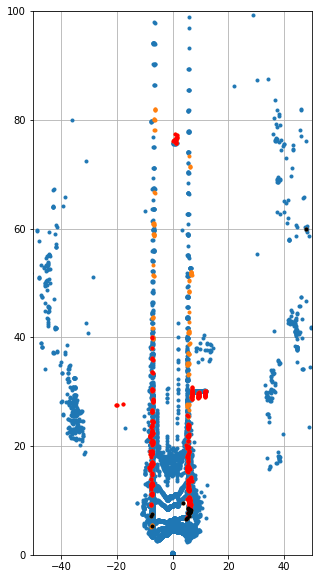

In [112]:
rad.process(data1['radar_ch3']['data'],data1['radar_ch0']['data'],data1['radar_ch1']['data'],data1['radar_ch2']['data'])


NBPts = rad.get_pcl(r,azimuth,elevation,power,doppler, x,y,z,v,size_max)
x = x[:NBPts]
y = y[:NBPts]
doppler = doppler[:NBPts]

print('Number of 3D points: ',NBPts)

plt.figure(figsize=(5,10))
plt.plot(-data1['scala']['data'][:,1],data1['scala']['data'][:,0],'.')

plt.plot(y,x,'.')
id=np.where(doppler>200)[0]
plt.plot(y[id],x[id],'r.')
id=np.where(doppler<20)[0]
plt.plot(y[id],x[id],'k.')
plt.xlim(-50,50)
plt.ylim(0.,100)
plt.grid()

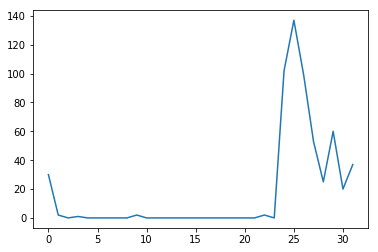

In [113]:
a,b = np.histogram(doppler,32,[0,255])
vV = np.argmax(a)*8
plt.plot(a)

In [94]:
np.median(doppler)

51.0

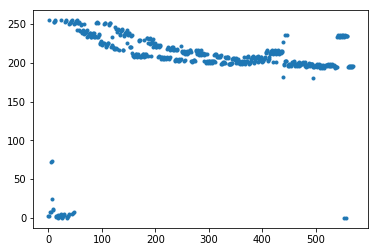

In [114]:
plt.plot(doppler,'.')

In [22]:
map = np.zeros((200*4,700*4))

for i in range(len(pts)):
    x = int(pts[i,0]*4)
    y = int(-pts[i,1]*4+400)
    
    map[y,x]+=1

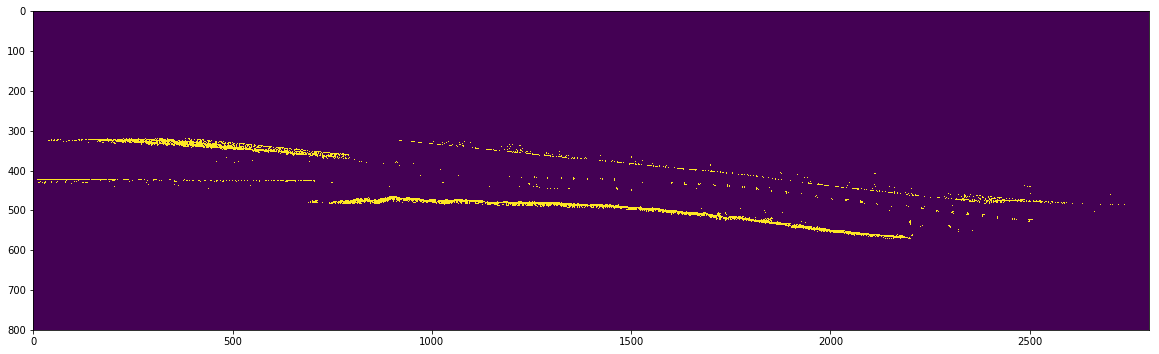

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(map>0)

In [37]:
timestamp1,timeofissue,sample,sensor,sample_number,data1=db.GetSensorData(1000)

#print('timestamp: ',timestamp,'timeofissue: ',timeofissue,'Sensor: ',sensor,'sample: ',sample)

SteeringWheel,YawRate,VehSpdAvgDrvn = db.GetMostRecentOdometry(can_decoder,timestamp1)

id = np.where((data1[:,0]>2) & (data1[:,0]<80) & (data1[:,1]<20) & (data1[:,1]>-20))[0]
data1=data1[id,:]

data1=remove_ground(data1)

In [38]:
timestamp2,timeofissue,sample,sensor,sample_number,data2=db.GetSensorData(1001)

#print('timestamp: ',timestamp,'timeofissue: ',timeofissue,'Sensor: ',sensor,'sample: ',sample)

SteeringWheel,YawRate,VehSpdAvgDrvn = db.GetMostRecentOdometry(can_decoder,timestamp2)

id = np.where((data2[:,0]>2) & (data2[:,0]<80) & (data2[:,1]<20) & (data2[:,1]>-20))[0]
data2=data2[id,:]

data2=remove_ground(data2)

In [39]:
# Estimate motiom
absolute_angle=0
dT_sec = (timestamp2-timestamp1)/1e6
relative_angle = -YawRate*dT_sec
absolute_angle +=relative_angle
dist = VehSpdAvgDrvn*1000/3600 *dT_sec
Dx = np.cos(absolute_angle/180*3.14)*dist
Dy = np.sin(absolute_angle/180*3.14)*dist

print(Dx,Dy,relative_angle)

1.1010555113677691 0.0001443752854118181 0.0075166875


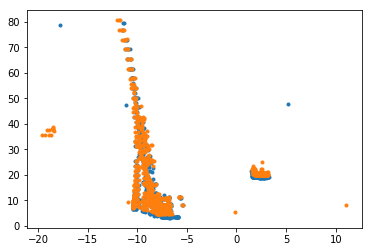

In [42]:
plt.plot(-data1[:,1],data1[:,0],'.')
plt.plot(-data2[:,1],data2[:,0]+Dx,'.')

In [71]:
map = np.zeros((500,200,2))

for i in range(len(data1)):
    x = int(data1[i,0]*5)
    y = int(-data1[i,1]*5+100)
    
    if(x>0 and x<500 and y>0 and y<200):
        map[x,y,0]+=data1[i,3]
        
for i in range(len(data2)):
    x = int((data2[i,0]+Dx)*5)
    y = int(-data2[i,1]*5+100)
    
    if(x>0 and x<500 and y>0 and y<200):
        map[x,y,1]+=1#data2[i,3]

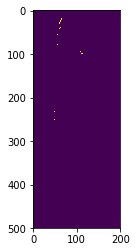

In [72]:
plt.imshow(np.abs(map[:,:,1]-map[:,:,0])>4)

### Open the dataset

In [38]:
db = SyncReader('/media/julien/HD_RADAR/FinalDataset/Pitch0Deg/RECORD@2020-11-22_12.43.28',master='camera',tolerance=100000)

-------------------------------------------------------------------------
- Sensors available:
-     camera
-     can
-     radar_ch2
-     scala
-     radar_ch1
-     radar_ch3
-     radar_ch0
-     gps
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  0.0 %


In [48]:
data1000 = db.GetSensorData(1010)
data1001 = db.GetSensorData(1011)

In [49]:
print(data1000['scala']['timestamp'])
print(data1001['scala']['timestamp'])

40268638
40308710


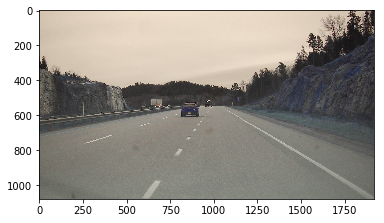

In [50]:
plt.imshow(data1000['camera']['data'])

In [198]:
can_decoder.decode(data1000['can']['data'])

[{'signals': {'TORSRotDir': 0,
   'TORSLstTransType': 0,
   'TORSRstOcrd': 0,
   'TORSValidity': 0,
   'TORSPulsCntr': 899,
   'TORSTimestamp': 8969},
  'timestamp': 40209196},
 {'signals': {'TrnsOvrallEstTorqRatioV': 0,
   'TrnsOvrallEstTorqRatio': 1.0,
   'TrnsOutShftAngVelV': 0,
   'TrnsOtptShftAngVelSnrPr': 1,
   'TrnsOtptRotRCRstOcc': 0,
   'TrnsOtptRotRCV': 0,
   'TrnsRqHSABrkPrDcyRt': 0,
   'TrnsDrvlneTqShpDisRq': 0,
   'TrnsOutShftAngVel': 636.5,
   'TrnsOtptRotRC': 450.515625,
   'TransDsrdTrqRatio': 0.5304},
  'timestamp': 40209197},
 {'signals': {'TrnsTrqRqALC': 2,
   'TIDCTR_TrqRespTyp': 0,
   'TIDCTR_TrqReqVal': 1199.5,
   'TIDCTR_TrqIntvTyp': 0,
   'TPCTR_TrqIntrvnTyp': 0,
   'TPCTR_TorqReqVal': 1199.5,
   'TrnsPdCrkshftTqRqPVa': 12287,
   'TrnsTrqCap': 1020},
  'timestamp': 40209199},
 {'signals': {'EngDgTrqCnvClUnlkRqd': 0,
   'EngCyDactTqSmtAct': 0,
   'ETGRReqType': 0,
   'ETGRReqdGear': 0,
   'EngBrkStat': 0,
   'ACCmCltEngd': 0,
   'TracCntlSysPwrtrnInhbt': 0,
   'E

In [56]:
steering,yaw,speed = db.GetMostRecentOdometry(can_decoder,data1000['scala']['timeofissue'])

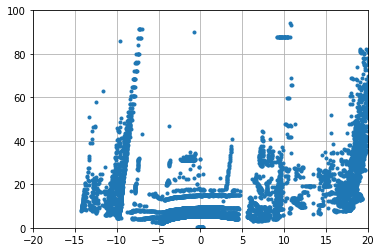

In [112]:
xyz1 = data1000['scala']['data'][:,:3]
plt.plot(-xyz1[:,1],xyz1[:,0],'.')
plt.ylim(0, 100)
plt.xlim(-20, 20)
plt.grid()

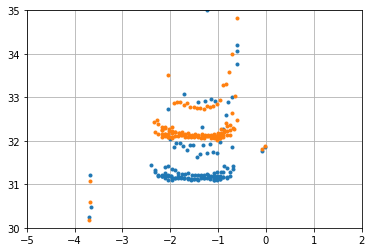

In [84]:
xyz1 = data1000['scala']['data'][:,:3]
xyz2 = data1001['scala']['data'][:,:3]
plt.plot(-xyz1[:,1],xyz1[:,0],'.')
plt.plot(-xyz2[:,1],xyz2[:,0]+speed/3.6*(data1001['scala']['timestamp']-data1000['scala']['timestamp'])/1000000,'.')
plt.ylim(30, 35)
plt.xlim(-5, 2)
plt.grid()

In [179]:
absolute_angle

0

In [180]:
data = ApplyCalib(data,sample_number,0)

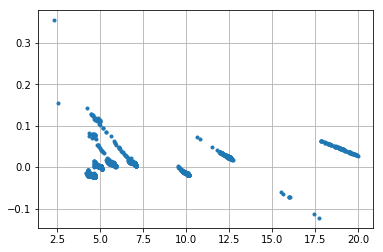

In [243]:
xyz1 = data[:,:3]

id = np.where( (xyz1[:,1]>-2) &  (xyz1[:,1]<2) & (xyz1[:,0]<20)& (xyz1[:,0]>2))[0]

plt.plot(xyz1[id,0],xyz1[id,2],'.')
plt.grid()

In [252]:
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
from sklearn import linear_model

def remove_ground(xyz):
    
    id = np.where( (xyz1[:,1]>-5) &  (xyz1[:,1]<5) & (xyz1[:,0]<25)& (xyz1[:,0]>2))[0]
    
    
    X = xyz1[id,0].reshape((-1, 1))
    y = xyz1[id,2]
    lr = linear_model.RANSACRegressor()
    lr.fit(X,y)
    id = np.where( (xyz[:,2] > 0.1+(xyz[:,0] * lr.estimator_.coef_[0])))[0]
    
    return xyz[id,:]

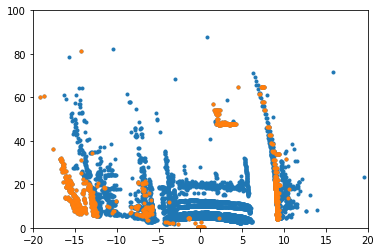

In [253]:
xyz2 = remove_ground(xyz1)

plt.plot(-xyz1[:,1],xyz1[:,0],'.')
plt.plot(-xyz2[:,1],xyz2[:,0],'.')
plt.grid()
plt.ylim(0, 100)
plt.xlim(-20, 20)
plt.grid()


In [254]:
X = xyz1[id,0].reshape((-1, 1))
y = xyz1[id,2]

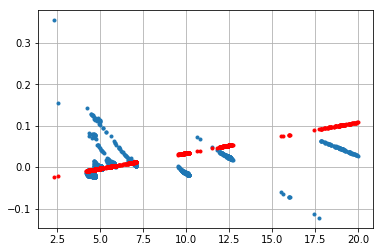

In [255]:
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
from sklearn import linear_model

lr = linear_model.RANSACRegressor()
lr.fit(X,y)


y_pred = lr.predict(X)
plt.plot(X,y,'.')
plt.plot(X,y_pred,'r.')
plt.grid()

In [228]:
lr.estimator_.coef_[0]

0.0023441933876203677

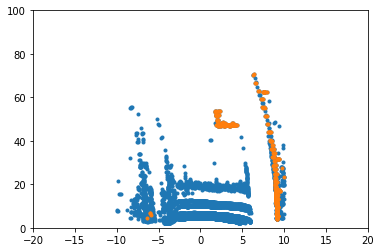

In [172]:
id = np.where( (xyz1[:,2] > (xyz1[:,0] * lr.coef_[0])))[0]
plt.plot(-xyz1[:,1],xyz1[:,0],'.')
plt.plot(-xyz1[id,1],xyz1[id,0],'.')
plt.grid()
plt.ylim(0, 100)
plt.xlim(-20, 20)
plt.grid()

### Go through the dataset

In [ ]:
# Create an iterator on the dataset
ite = iter(db)
pcd = o3d.geometry.PointCloud()

# iterate through the entire dataset
# it replays the data with the same order it has been recorded
#it s sequential, that is to say each data will be from one of the sensor, but
# not all at the same time
for i in range(len(db)):
    timestamp,sample,sensor,data=next(ite)
    
    print('timestamp: ',timestamp,'Sensor: ',sensor,'sample: ',sample)

In [ ]:
timestamp,sample,sensor,data=db.GetSensorData(0)
xyz = data[:,:3]

In [ ]:

pcd.points = o3d.utility.Vector3dVector(xyz[:,:3])
o3d.visualization.draw_geometries([pcd])

In [ ]:
sensor